In [27]:
# this code is used for revise everything to make it easier for evalution.
# check if +1, -1 works well here.
# updated date: 20240204 19:35

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

# dataset pre-prossessing
Batch_size=16
Batch_size_test=16
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load train and test set
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [30]:
''' if choose two classes to do bianry classification
run this part 
'''
# choose two classes to do binary classification
# original label : 0 to 9
# after choosing two classese, transform the label to -1 and +1, the smaller label will be assigned to -1, 
# larger label will be assigned to +1.

chosen_classes=[0,1] # choose the label here.
if chosen_classes[0]>chosen_classes[1]: # ensure that chosen_classes[0]<chosen_classes[1]
    temp=chosen_classes[0]
    chosen_classes[0]=chosen_classes[1]
    chosen_classes[1]=temp

# build data loaders
trainset=[]
testset=[]

for data in trainset_full:
    #print(data)
    if data[1] == chosen_classes[0]:
        #trainset.append((data[0],0)) # beacuse data is tuple, we can't directly change the value.
        trainset.append((data[0],-1)) 
    if data[1] == chosen_classes[1]:
        #data[1]=1
        trainset.append((data[0],1))

for data in testset_full:
    if data[1] == chosen_classes[0]:
        #data[1]=0
        #testset.append((data[0],0))
        testset.append((data[0],-1))
    if data[1] == chosen_classes[1]:
       # data[1]=1
        testset.append((data[0],1))

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_size_test, shuffle=False, num_workers=2)

In [31]:
# ''' if we want to do one vs other bianry classification
# run this part
# '''
# chosen_classes=[0]

# trainset=[]
# testset=[]

# for data in trainset_full:
#     if data[1] == chosen_classes[0]:
#         trainset.append((data[0],0)) # beacuse data is tuple, we can't directly change the value.
#     else:
#         trainset.append((data[0],1))

# for data in testset_full:
#     if data[1] == chosen_classes[0]:
#         #data[1]=0
#         testset.append((data[0],0))
#     else:
#        # data[1]=1
#         testset.append((data[0],1))

# # Create data loaders
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size, shuffle=True, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_size_test, shuffle=False, num_workers=2)

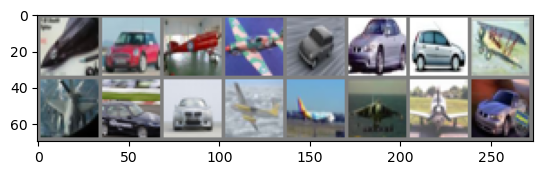

tensor(-1) tensor(1) tensor(-1) tensor(-1) tensor(1) tensor(1) tensor(1) tensor(-1) tensor(-1) tensor(1) tensor(1) tensor(-1) tensor(-1) tensor(-1) tensor(-1) tensor(1)


In [32]:
# 
import matplotlib.pyplot as plt
import numpy as np

# function that shows the image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# randomly choose a image
dataiter = iter(trainloader)
#images, labels = dataiter.next()
images, labels = next(dataiter)

# show the image
imshow(torchvision.utils.make_grid(images))
# print the label
print(' '.join('%5s' % labels[j] for j in range(Batch_size)))

In [33]:
print(images[0].size())

torch.Size([3, 32, 32])


In [34]:
# define the local model
import torch.nn as nn
import torch.nn.functional as F


class LocalNet(nn.Module):
    def __init__(self):
        super(LocalNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(3 * 32 * 32, 120)

        self.fc2 = nn.Linear(3 * 32 * 32, 1)


    def forward(self, x):

        x = x.view(-1, 3 * 32 * 32)

        x = self.fc2(x)
        
        return x


#mobile_net = LocalNet()
mobile_net = LocalNet().to(device)

In [35]:
# loss function, optimizer, backward
import torch.optim as optim

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.SGD(mobile_net.parameters(), lr=0.001, momentum=0.9)

In [36]:
# training
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        #inputs, labels = data
        inputs, labels = data[0].to(device),data[1].to(device)
        #labels=labels*2-1
        labels=torch.reshape(labels, (Batch_size, 1))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mobile_net(inputs)
        #outputs = (outputs+1)/2
        
        #print(labels)
        #print(outputs)
        
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [37]:
PATH = './cifar_localnet.pth'
torch.save(mobile_net.state_dict(), PATH)

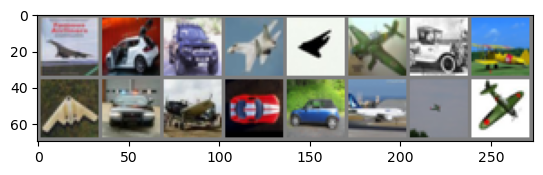

GroundTruth:  tensor(-1) tensor(1) tensor(1) tensor(-1) tensor(-1) tensor(-1) tensor(1) tensor(-1) tensor(-1) tensor(1) tensor(-1) tensor(1) tensor(1) tensor(-1) tensor(-1) tensor(-1)


In [38]:
# testing
dataiter = iter(testloader)
#images, labels = dataiter.next()
images, labels = next(dataiter)

# 输出图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(Batch_size_test)))

In [39]:
mobile_net = LocalNet().to(device)
mobile_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [40]:
outputs = mobile_net(images.to(device))

In [41]:
#_, predicted = torch.max(outputs, 1)
#predicted =  = (torch.sign(outputs)+1)/2
predicted = [1 if x > 0 else -1 for x in outputs]

print('Predicted: ', ' '.join('%5s' % predicted[j] for j in range(Batch_size_test)))


Predicted:     -1     1    -1    -1    -1    -1    -1    -1     1     1    -1     1     1    -1    -1    -1


In [42]:
# need batch size > 1  done
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        #images, labels = data
        images, labels = data[0].to(device),data[1].to(device)
        outputs = mobile_net(images)
        #_, predicted = torch.max(outputs.data, 1)
        predicted = [1 if x > 0 else -1 for x in outputs]
        predicted=torch.tensor(predicted).to(device)
        #print(type(predicted))
        #print(type(labels))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
#print(total)
print('Accuracy of the network on the 2000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 2000 test images: 71 %


In [43]:
#Let's see the class-wise accuracy in mobile device

In [44]:
# need batch size > 1  done
correct = 0
total = 0
correct_1=0
correct_0=0
with torch.no_grad():
    for data in testloader:
        #images, labels = data
        images, labels = data[0].to(device),data[1].to(device)
        outputs = mobile_net(images)
        #_, predicted = torch.max(outputs.data, 1)
        predicted = [1 if x > 0 else -1 for x in outputs]
        predicted=torch.tensor(predicted).to(device)
        #print(type(predicted))
        #print(type(labels))
        #print(predicted)
        #print(labels)
        total += labels.size(0)
        #correct_1 += (predicted == labels and labels==1).sum().item()
        correct_1 += ((predicted == labels) * (labels==1)).sum().item()
        #correct_0+=(predicted == labels and labels==0).sum().item()
        correct_0+=((predicted == labels) * (labels==-1)).sum().item()
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
print('Total sample size: %d' %total)
print('correct 1: %d'%correct_1)
print('correct 0: %d'%correct_0)

Accuracy of the network on the test images: 71 %
Total sample size: 2000
correct 1: 612
correct 0: 822


Now we have fixed local classifier. Let's build the mobile-edge-cloud system.

In [55]:
# Define the edge model
Batch_size_test=1
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_size_test, shuffle=False, num_workers=2)


c1=1
#ce=0.15 #20% reject rate
#ce=0.18 # 5% reject rate
#ce=0.16 # 12.5% reject rate
ce=0 # 45% reject rate @ 30 epoches  
#ce=0.01 #35% reject rate
class EdgeNet(nn.Module):
    def __init__(self):
        super(EdgeNet, self).__init__()
        
        #rejector
        self.rj1=  nn.Linear(3 * 32 * 32, 120)
        self.rj2=  nn.Linear(120, 1)
        
        #edge classifier
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # reject
        y = x.view(-1, 3 * 32 * 32)
        y = F.relu(self.rj1(y))
        y = self.sigmoid(self.rj2(y))*2-1
        #print(y)
        #m=fixed_mobile_net(x)
        
        #edge classifier
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))*2-1
        #print(x)
    
        return [y,x]

# edge_net = EdgeNet()
edge_net = EdgeNet().to(device)

In [56]:
# solve the issue in batch_size>1: done!
import torch.optim as optim
import math
#custom loss function
def surrogate_loss(outputs, labels, mobile_outputs):
    # here labels={-1. +1}, so we have to pre-processing before input labels
    r,e=outputs[0],outputs[1]
    #print(r,e)
    #value, predicted = torch.max(mobile_outputs.data, 1)
    mobil_predicted = [1 if x > 0 else -1 for x in mobile_outputs] #m={-1, +1}
    #print(mobil_predicted)
    mobil_predicted=torch.tensor(mobil_predicted).to(device)
    
    #we assume P(m!=Y|X=x)=0.3 in this case
    value =0.18  # assume that the error rate for each input x is constant.
    beta = 2

    alpha=beta*(ce+math.sqrt(4*c1*(value-ce)-4*value*value+8*ce*value-4*ce*ce))/(2*value)

    mobil_predicted=mobil_predicted.unsqueeze(1)  # transform shape from [batch_size] to [batch_size, 1], to fit the size of labels. Otherwise accept=mobil_predicted!=labels would lead to [batch_size, batch_size] instead of [batch_size,1](desired)

    accept=mobil_predicted!=labels

    loss=accept*torch.exp(alpha*r)+c1*torch.exp(-r-labels*e)+ce*torch.exp(-r)

    return torch.sum(loss)
    #return torch.mean(loss)

#criterion=surrogate_loss
optimizer = optim.SGD(edge_net.parameters(), lr=0.0001, momentum=0.9) #0.0001

In [57]:
# # training and store the best model locally
# #training
# PAHT_edge='./cifar_edgenet.pth'
# best_accuracy=0
# for epoch in range(30):  # loop over the dataset multiple times [2, 5, 10,30]

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs
#         #inputs, labels = data
#         inputs, labels = data[0].to(device),data[1].to(device)
#         #print(labels[0])
#         #labels=labels*2-1
#         labels=torch.reshape(labels, (Batch_size, 1)).to(device) #this part is ok 
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = edge_net(inputs)
#         #print(outputs[0],outputs[1])
#         #something wrong happened here.
        
        
#         mobile_outputs=mobile_net(inputs) #this part is ok
#         #print(mobile_outputs.item())
#         #mobile_outputs.requires_grad_(False)
#         loss = surrogate_loss(outputs, labels, mobile_outputs.detach()).to(device)
#         #print(loss)
#         loss.backward()
#         optimizer.step()
          
        
#         # print statistics
#         running_loss += loss.item()
#         if i % 500 == 499:    # print every 500 mini-batches
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
#             running_loss = 0.0
#         #break

#     #after one epoch, validate the accuracy on testing set and store the best
#     correct = 0
#     total = 0
#     predict_locally=0
#     predict_remotely=0
#     with torch.no_grad(): # 
#         for data in testloader:
#             #images, labels = data
#             images, labels = data[0].to(device),data[1].to(device)
#             # print(images.shape)
#             #print(labels)
#             edge_outputs = edge_net(images)
#             mobile_outputs = mobile_net(images)
#             r, e=edge_outputs[0].to(device),edge_outputs[1].to(device)
#             # print(mobile_outputs)
#             # print(r)
#             # print(e)
            
#             predict_locally+=(r>0).sum().item()
#             predict_remotely+=(r<=0).sum().item()
#             overal_output=mobile_outputs*(r>0)+e*(r<=0)
#             predicted=[1 if x > 0 else -1 for x in overal_output]
#             predicted=torch.tensor(predicted).to(device)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     current_accuracy=1.0*correct/total
#     print('Accuracy of the network on the 2000 test images: %d %%' % (100 * current_accuracy))
#     if current_accuracy>best_accuracy:
#         best_accuracy=current_accuracy
#         torch.save(edge_net.state_dict(), PAHT_edge)
# print('Finished Training')

# #load the best model
# edge_net = EdgeNet().to(device)
# edge_net.load_state_dict(torch.load(PAHT_edge))

In [58]:
#training

for epoch in range(30):  # loop over the dataset multiple times [2, 5, 10,30]

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        #inputs, labels = data
        inputs, labels = data[0].to(device),data[1].to(device)
        #print(labels[0])
        #labels=labels*2-1
        labels=torch.reshape(labels, (Batch_size, 1)).to(device) #this part is ok 
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = edge_net(inputs)
        #print(outputs[0],outputs[1])
        #something wrong happened here.
        
        
        mobile_outputs=mobile_net(inputs) #this part is ok
        #print(mobile_outputs.item())
        #mobile_outputs.requires_grad_(False)
        loss = surrogate_loss(outputs, labels, mobile_outputs.detach()).to(device)
        #print(loss)
        loss.backward()
        optimizer.step()
          
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0
        #break
print('Finished Training')

[1,   500] loss: 19.609
[2,   500] loss: 16.607
[3,   500] loss: 14.506
[4,   500] loss: 13.378
[5,   500] loss: 12.270
[6,   500] loss: 11.708
[7,   500] loss: 11.291
[8,   500] loss: 11.333
[9,   500] loss: 10.426
[10,   500] loss: 10.277
[11,   500] loss: 9.973
[12,   500] loss: 9.823
[13,   500] loss: 9.710
[14,   500] loss: 9.272
[15,   500] loss: 9.298
[16,   500] loss: 8.996
[17,   500] loss: 9.969
[18,   500] loss: 8.683
[19,   500] loss: 8.405
[20,   500] loss: 8.984
[21,   500] loss: 8.463
[22,   500] loss: 8.206
[23,   500] loss: 9.745
[24,   500] loss: 8.446
[25,   500] loss: 7.745
[26,   500] loss: 8.216
[27,   500] loss: 7.619
[28,   500] loss: 7.920
[29,   500] loss: 7.636
[30,   500] loss: 8.723
Finished Training


In [59]:
# # testing
# correct = 0
# total = 0
# predict_locally=0
# predict_remotely=0
# with torch.no_grad(): # 
#     for data in testloader:
#         #images, labels = data
#         images, labels = data[0].to(device),data[1].to(device)
#         # print(images.shape)
#         # print(labels)
#         edge_outputs = edge_net(images)
#         mobile_outputs = mobile_net(images)
#         r, e=edge_outputs[0].to(device),edge_outputs[1].to(device)
#         # print(mobile_outputs)
#         # print(r)
#         # print(e)
        
#         #if r*2-1>0: #assume that interval of r is [0,1]
#         if r>0:
#             # predict locally
#             predict_locally+=1
#             predicted = [1 if x > 0 else -1 for x in mobile_outputs]
#             predicted=torch.tensor(predicted).to(device)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#         else:
#             predict_remotely+=1
#             predicted = [1 if x > 0 else -1 for x in e]
#             predicted=torch.tensor(predicted).to(device)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()            

# print("Decision made locally:%d" %predict_locally)
# print("Decision made on edge:%d" %predict_remotely)
# print('Accuracy of the network on the 2000 test images: %d %%' % (
#     100 * correct / total))

In [60]:
# testing 
# batch size > 1  it's working now!
correct = 0
total = 0
predict_locally=0
predict_remotely=0
with torch.no_grad(): # 
    for data in testloader:
        #images, labels = data
        images, labels = data[0].to(device),data[1].to(device)
        # print(images.shape)
        #print(labels)
        edge_outputs = edge_net(images)
        mobile_outputs = mobile_net(images)
        r, e=edge_outputs[0].to(device),edge_outputs[1].to(device)
        # print(mobile_outputs)
        # print(r)
        # print(e)
        
        predict_locally+=(r>0).sum().item()
        predict_remotely+=(r<=0).sum().item()
        overal_output=mobile_outputs*(r>0)+e*(r<=0)
        predicted=[1 if x > 0 else -1 for x in overal_output]
        predicted=torch.tensor(predicted).to(device)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # if r>0:
        #     # predict locally
        #     predict_locally+=1
        #     predicted = [1 if x > 0 else -1 for x in mobile_outputs]
        #     predicted=torch.tensor(predicted).to(device)
        #     total += labels.size(0)
        #     correct += (predicted == labels).sum().item()
        # else:
        #     predict_remotely+=1
        #     predicted = [1 if x > 0 else -1 for x in e]
        #     predicted=torch.tensor(predicted).to(device)
        #     total += labels.size(0)
        #     correct += (predicted == labels).sum().item()            

print("Decision made locally:%d" %predict_locally)
print("Decision made on edge:%d" %predict_remotely)
print('Accuracy of the network on the 2000 test images: %d %%' % (
    100 * correct / total))

Decision made locally:1052
Decision made on edge:948
Accuracy of the network on the 2000 test images: 90 %


In [61]:
#only run the edge:
# batch size > 1  it's working now!
correct = 0
total = 0
predict_locally=0
predict_remotely=0
correct_1=0
correct_0=0
with torch.no_grad():
    for data in testloader:
        #images, labels = data
        images, labels = data[0].to(device),data[1].to(device)
        edge_outputs = edge_net(images)
        mobile_outputs = mobile_net(images).to(device)
        r, e=edge_outputs[0].to(device),edge_outputs[1].to(device)
        #print(mobile_outputs)
        #print(r)
        #print(e)

        predict_remotely+=labels.size(0)
        #print(e)
        predicted = [1 if x > 0 else -1 for x in e]
        predicted=torch.tensor(predicted).to(device)
        #print(predicted)
        total += labels.size(0)
        #correct_1 += (predicted == labels and labels==1).sum().item()
        correct_1 += (predicted == labels * (labels==1)).sum().item()
        #correct_0+=(predicted == labels and labels==0).sum().item()
        correct_0+=(predicted == labels * (labels==-1)).sum().item()
        correct += (predicted == labels).sum().item()            

print(predict_locally)
print(predict_remotely)
print('Accuracy of the network on the 2000 test images: %d %%' % (
    100 * correct / total))
print('Total sample size: %d' %total)
print('correct 1: %d'%correct_1)
print('correct 0: %d'%correct_0)

0
2000
Accuracy of the network on the 2000 test images: 93 %
Total sample size: 2000
correct 1: 957
correct 0: 920


In [62]:
# mobile and edge work together,
# there is unbalance happen to rejection

In [63]:
# this part did a lot analysis, so we let Batch_size_test=1
Batch_size_test=1
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_size_test, shuffle=False, num_workers=2)
correct = 0
total = 0
predict_locally=0
predict_remotely=0
local_1=0
local_0=0
edge_1=0
edge_0=0

local_correct_1=0
local_correct_0=0
edge_correct_0=0
edge_correct_1=0
local_correct_edgeSample_0=0
local_correct_edgeSample_1=0
edge_correct_mobilesample_0=0
edge_correct_mobilesample_1=0
mobile_equal_edge_locally_0=0
mobile_equal_edge_remotely_0=0

with torch.no_grad():
    for data in testloader:
        #images, labels = data
        images, labels = data[0].to(device),data[1].to(device)
        #print(labels)
        edge_outputs = edge_net(images)
        mobile_outputs = mobile_net(images)
        r, e=edge_outputs[0].to(device),edge_outputs[1].to(device)
        #print(mobile_outputs)
        #print(r)
        #print(e)
        
        #if r*2-1>0: #assume that interval of r is [0,1]
        if r>0:
            # predict locally
            predict_locally+=1
            predicted = [1 if x > 0 else -1 for x in mobile_outputs]
            predicted=torch.tensor(predicted).to(device)
            edge_predicted= [1 if x > 0 else -1 for x in e]
            edge_predicted=torch.tensor(edge_predicted).to(device)
            total += labels.size(0)
            local_1 += (labels == 1).sum().item()
            local_0 += (labels == -1).sum().item()

            local_correct_0+=((predicted == labels) * (labels==(-1))).sum().item()

            edge_correct_mobilesample_0+=(edge_predicted == labels * (labels==(-1))).sum().item()

            local_correct_1+=(predicted == labels * (labels==1)).sum().item()

            edge_correct_mobilesample_1+=(edge_predicted == labels * (labels==1)).sum().item()
            
            mobile_equal_edge_locally_0+=(predicted == labels * (labels==(-1)) * edge_predicted== labels).sum().item()
            correct += (predicted == labels).sum().item()
        else:
            predict_remotely+=1
            predicted = [1 if x > 0 else -1 for x in e]
            local_predicted=[1 if x > 0 else -1 for x in mobile_outputs]
            local_predicted=torch.tensor(local_predicted).to(device)
            predicted=torch.tensor(predicted).to(device)
            total += labels.size(0)
            edge_0+=(labels== -1).sum().item()
            edge_1+=(labels==1).sum().item()

            edge_correct_0+=(predicted == labels * (labels==(-1))).sum().item()

            local_correct_edgeSample_0+=(local_predicted == labels * (labels==(-1))).sum().item()
 
            mobile_equal_edge_remotely_0+=(local_predicted == labels * (labels==(-1)) * predicted == labels).sum().item()

            edge_correct_1+=(predicted == labels * (labels==1)).sum().item()

            local_correct_edgeSample_1+=(local_predicted == labels * (labels==1)).sum().item()
            correct += (predicted == labels).sum().item()            

print("Decision made locally:%d" %predict_locally)
print("local true 1: %d, accuracy: %d %%, accuracy for edge classifier on those samples %d %%"%(local_1, 100*local_correct_1/local_1,100*edge_correct_mobilesample_1/local_1))
print("local true 0: %d, accuracy: %d %%, accuracy for edge classifier on those samples %d %%"%(local_0, 100*local_correct_0/local_0,100*edge_correct_mobilesample_0/local_0))
print("edge = mobile =0 locally: %d"%(mobile_equal_edge_locally_0))
print("Decision made on edge:%d" %predict_remotely)
print("edge true 1: %d, accuracy:%d %%, accuracy for mobile classifier on those samples %d %%"%(edge_1, 100*edge_correct_1/edge_1, 100*local_correct_edgeSample_1/edge_1))
print("edge true 0: %d, accuracy:%d %%, accuracy for mobile classifier on those samples %d %%"%(edge_0, 100*edge_correct_0/edge_0,100*local_correct_edgeSample_0/edge_0 ))
print("edge = mobile =0 remotely: %d"%(mobile_equal_edge_remotely_0))
print('Accuracy of the network on the 2000 test images: %d %%' % (
    100 * correct / total))


Decision made locally:1052
local true 1: 482, accuracy: 84 %, accuracy for edge classifier on those samples 96 %
local true 0: 570, accuracy: 92 %, accuracy for edge classifier on those samples 94 %
edge = mobile =0 locally: 19
Decision made on edge:948
edge true 1: 518, accuracy:95 %, accuracy for mobile classifier on those samples 39 %
edge true 0: 430, accuracy:88 %, accuracy for mobile classifier on those samples 68 %
edge = mobile =0 remotely: 27
Accuracy of the network on the 2000 test images: 90 %
